In [ ]:
import pickle
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from os.path import exists
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# Loading the Files
trainingSet = pd.read_csv("/content/drive/My Drive/Colab Data/cs-506-midterm-fall-2024/train.csv")
testingSet = pd.read_csv("/content/drive/My Drive/Colab Data/cs-506-midterm-fall-2024/test.csv")

# Define a function to add features to the dataframes
def add_features_to(df, fit=False):
    # Basic feature extraction
    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)

    # Ensure 'Text' is non-null
    df['Text'] = df['Text'].fillna('')

    global tfidf_vectorizer, pca
    if fit:
        tfidf_vectorizer = TfidfVectorizer(max_features=5000)
        pca = PCA(n_components=100, random_state=0)
        tfidf_matrix = tfidf_vectorizer.fit_transform(df['Text'])
        df_pca = pca.fit_transform(tfidf_matrix.toarray())
    else:
        tfidf_matrix = tfidf_vectorizer.transform(df['Text'])
        df_pca = pca.transform(tfidf_matrix.toarray())

    # Create DataFrame from PCA-transformed text features
    df_pca = pd.DataFrame(df_pca, columns=[f'pca_{i}' for i in range(df_pca.shape[1])])
    df = pd.concat([df, df_pca], axis=1).drop(columns=['Text'])

    return df

In [ ]:
# Load or process the data
if exists('/content/drive/My Drive/Colab Data/cs-506-midterm-fall-2024/X_train.csv'):
    X_train = pd.read_csv("/content/drive/My Drive/Colab Data/cs-506-midterm-fall-2024/X_train.csv")
    X_submission = pd.read_csv("/content/drive/My Drive/Colab Data/cs-506-midterm-fall-2024/X_submission.csv")
else:
    train = add_features_to(trainingSet, fit=True)
    X_submission = add_features_to(pd.merge(train, testingSet, left_on='Id', right_on='Id', how='right'))
    X_submission = X_submission.drop(columns=['Score_x']).rename(columns={'Score_y': 'Score'})
    X_train = train[train['Score'].notnull()]
    X_submission.to_csv("/content/drive/My Drive/Colab Data/cs-506-midterm-fall-2024/X_submission.csv", index=False)
    X_train.to_csv("/content/drive/My Drive/Colab Data/cs-506-midterm-fall-2024/X_train.csv", index=False)

# Split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(columns=['Score']),
    X_train['Score'],
    test_size=0.25,
    random_state=0
)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Define a parameter grid for Logistic Regression
param_grid = {
    'C': [0.1, 1, 10],  # Inverse regularization strength
    'max_iter': [100, 200, 300]  # Maximum number of iterations for convergence
}

# Use RandomizedSearchCV for Logistic Regression
logreg_model = LogisticRegression(random_state=0, solver='liblinear')  # Using liblinear for smaller datasets
random_search = RandomizedSearchCV(logreg_model, param_distributions=param_grid, n_iter=3, cv=3, scoring='accuracy', random_state=0)
random_search.fit(X_train_select, Y_train)

# Best model from RandomizedSearch
best_logreg_model = random_search.best_estimator_
Y_test_predictions = best_logreg_model.predict(X_test_select)

# Model Evaluation
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

Accuracy on testing set =  0.5362178727621346


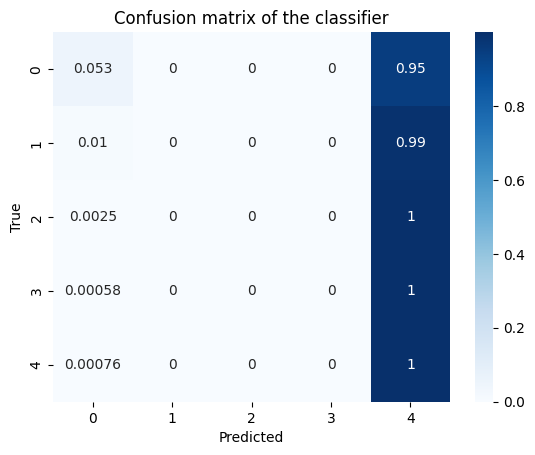

In [ ]:
# Confusion Matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True, cmap="Blues")
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create submission file
X_submission['Score'] = best_logreg_model.predict(X_submission_select)
submission = X_submission[['Id', 'Score']]
submission.to_csv("/content/drive/My Drive/Colab Data/cs-506-midterm-fall-2024/submission.csv", index=False)


In [ ]:
from google.colab import files

# Download the submission file
files.download("/content/drive/My Drive/Colab Data/cs-506-midterm-fall-2024/submission.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print(trainingSet.head())
print()
print(testingSet.head())

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays with you   

                                                Text  S